# Model Development

## Imports

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim

from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [71]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [ ]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [73]:
# Definir a estratégia de cross-validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Criar scorer personalizado para F-beta (beta=2)
fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Static Approach

### Naive Bayes

In [ ]:
search_space = {
    "var_smoothing": (1e-12, 1e-1, "log-uniform")
}

nb_opt = BayesSearchCV(
    estimator=GaussianNB(),
    search_spaces=search_space,
    scoring="roc_auc",  # You can also use "roc_auc" etc.
    cv=cv,
    n_iter=30,  # Number of optimization steps
    n_jobs=-1,
    random_state=42
)

nb_opt.fit(X, y)

best_params = nb_opt.best_params_

print("Best parameters:", nb_opt.best_params_)
print("Best ROC AUC score (cv):", nb_opt.best_score_)

Best parameters: OrderedDict([('var_smoothing', 0.1)])
Best ROC AUC score (cv): 0.8941591704147926


In [109]:
nb = GaussianNB(**best_params)
scores_nb = cross_validate(nb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Naive Bayes:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_nb[f"test_{metric}"])
    std_score = np.std(scores_nb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Naive Bayes:
Accuracy: 0.8430 ± 0.0804
Precision: 0.8439 ± 0.1006
Recall: 0.7996 ± 0.1029
Fbeta_2: 0.8068 ± 0.0958
Roc_auc: 0.8942 ± 0.0901


### Logistic Regression

In [ ]:
search_space = {
    'C': (1e-4, 1e+3, 'log-uniform'),  # regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

lr_opt = BayesSearchCV(
    LogisticRegression(max_iter=1000),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42
)

lr_opt.fit(X, y)

best_params = lr_opt.best_params_

print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", lr_opt.best_score_)

Best parameters: OrderedDict([('C', 0.12996535162010367), ('penalty', 'l2'), ('solver', 'liblinear')])
Best F-beta score (cv): 0.9097851074462768


In [98]:
lr = LogisticRegression(**best_params)
scores_lr = cross_validate(lr, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Logistic Regression:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_lr[f"test_{metric}"])
    std_score = np.std(scores_lr[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Logistic Regression:
Accuracy: 0.8467 ± 0.0980
Precision: 0.8317 ± 0.0957
Recall: 0.8163 ± 0.1406
Fbeta_2: 0.8185 ± 0.1307
Roc_auc: 0.9098 ± 0.0804


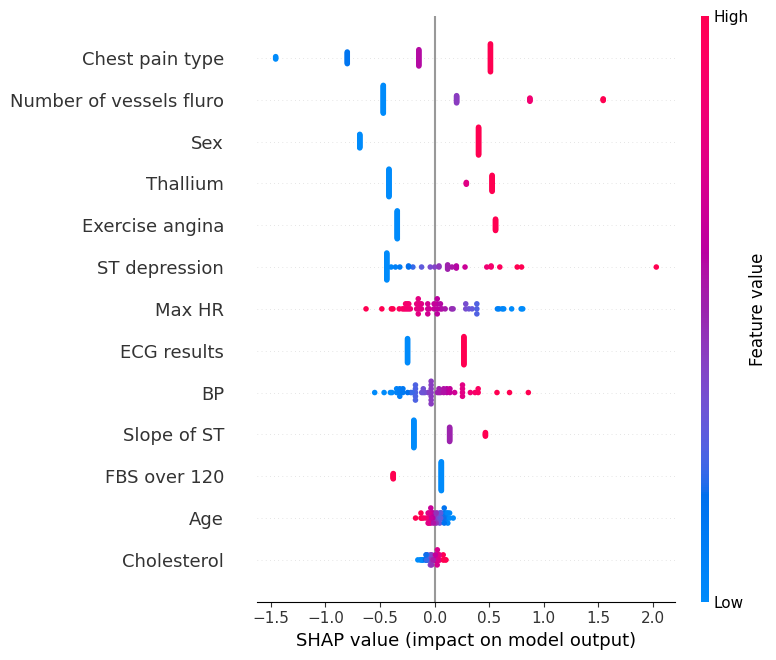

In [99]:
lr.fit(X_train, y_train)
explainer = shap.LinearExplainer(lr, X_train)  # Optimized for linear models
shap_values = explainer.shap_values(X_test)  # Compute SHAP values

# Feature importance visualization
shap.summary_plot(shap_values, X_test)

### Random Forest

In [101]:
search_space = {
    'n_estimators': (10, 500),  # Number of trees
    'max_depth': (1, 50),  # Maximum depth of each tree
    'min_samples_split': (2, 20),  # Minimum samples required to split an internal node
    'min_samples_leaf': (1, 20),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Max features to consider for each split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

opt_rf = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,  # Number of iterations for the search
    n_jobs=-1,  # Use all available CPUs
    random_state=42
)

# Fit the model
opt_rf.fit(X, y)

best_params = opt_rf.best_params_

# Print the best parameters and the best ROC-AUC score
print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", opt_rf.best_score_)

Best parameters: OrderedDict([('bootstrap', False), ('max_depth', 39), ('max_features', 'log2'), ('min_samples_leaf', 18), ('min_samples_split', 13), ('n_estimators', 301)])
Best ROC AUC score (cv): 0.9181679993336666


In [102]:
rf = RandomForestClassifier(**best_params)
scores_rf = cross_validate(rf, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Random Forest:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_rf[f"test_{metric}"])
    std_score = np.std(scores_rf[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Random Forest:
Accuracy: 0.8580 ± 0.0955
Precision: 0.8783 ± 0.1116
Recall: 0.7909 ± 0.1229
Fbeta_2: 0.8062 ± 0.1195
Roc_auc: 0.9159 ± 0.0695


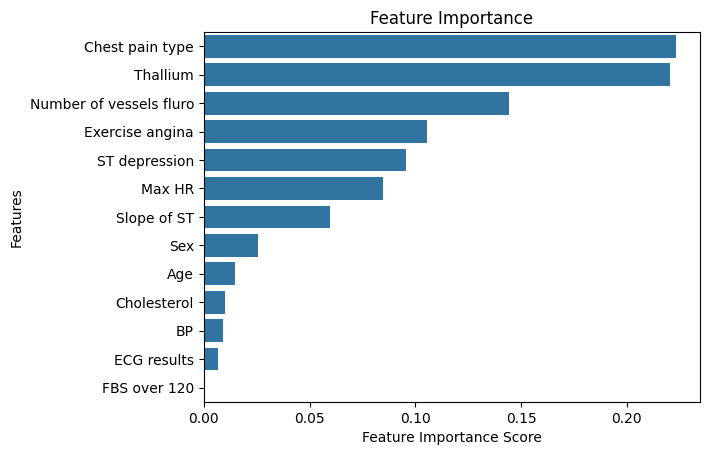

In [103]:
rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### XGBoost

In [104]:
search_space = {
    'n_estimators': (10, 500),  # Number of trees
    'max_depth': (1, 50),  # Maximum depth of each tree
    'learning_rate': (0.001, 0.1, 'uniform'),  # Learning rate
    'subsample': (0.5, 1.0),  # Subsample ratio of the training data
    'colsample_bytree': (0.5, 1.0),  # Subsample ratio of features
    'gamma': (0, 5),  # Regularization parameter
    'min_child_weight': (1, 20)  # Minimum sum of instance weight (hessian) needed in a child
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up Bayesian Optimization for XGBoost
opt_xgb = BayesSearchCV(
    XGBClassifier(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,  # Number of iterations for the search
    n_jobs=-1,  # Use all available CPUs
    random_state=42
)

# Fit the model
opt_xgb.fit(X, y)

best_params = opt_xgb.best_params_

# Print the best parameters and the best ROC-AUC score
print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", opt_xgb.best_score_)

Best parameters: OrderedDict([('colsample_bytree', 0.5030303068830654), ('gamma', 1), ('learning_rate', 0.08196684430569222), ('max_depth', 6), ('min_child_weight', 6), ('n_estimators', 208), ('subsample', 0.8818618831470533)])
Best ROC AUC score (cv): 0.9168215892053974


In [105]:
xgb = XGBClassifier(**best_params) 
scores_xgb = cross_validate(xgb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_xgb[f"test_{metric}"])
    std_score = np.std(scores_xgb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores XGBoost:
Accuracy: 0.8509 ± 0.0554
Precision: 0.8500 ± 0.0745
Recall: 0.8159 ± 0.0850
Fbeta_2: 0.8205 ± 0.0741
Roc_auc: 0.9202 ± 0.0579


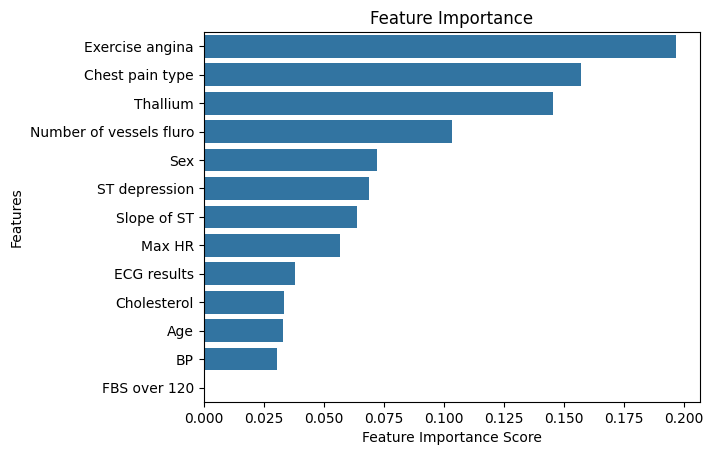

In [106]:
xgb.fit(X_train, y_train)

feature_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [83]:
pred = xgb.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(xgb)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

np.float32(2.861023e-06)

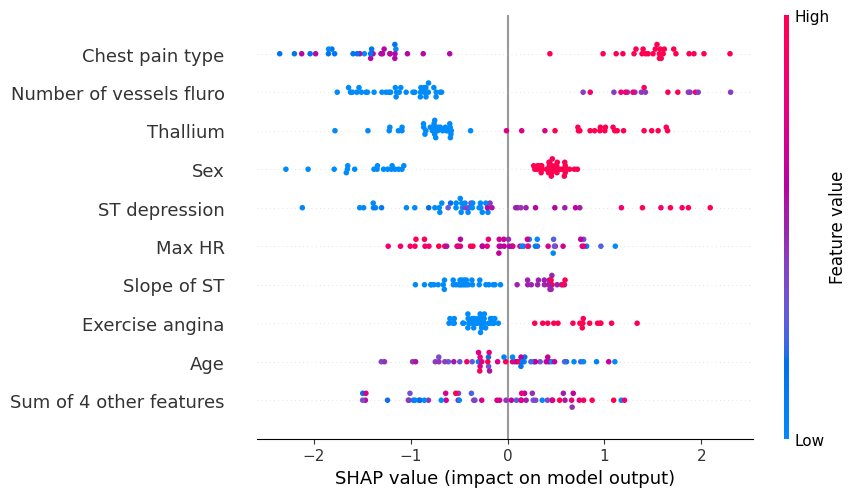

In [84]:
shap.plots.beeswarm(explanation)

### Support Vector Machine

In [107]:
search_space = {
    'C': (0.1, 100),  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'degree': (2, 5),  # Degree of the polynomial kernel (only used for 'poly')
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'coef0': (0, 10)  # Independent term in kernel function (only used for 'poly' and 'sigmoid')
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up Bayesian Optimization for SVM
opt_svm = BayesSearchCV(
    SVC(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",  # Use ROC AUC directly
    cv=cv,
    n_iter=30,  # Number of iterations for the search
    n_jobs=-1,  # Use all available CPUs
    random_state=42
)

# Fit the model
opt_svm.fit(X, y)

best_params = opt_svm.best_params_

# Print the best parameters and the best ROC-AUC score
print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", opt_svm.best_score_)

Best parameters: OrderedDict([('C', 0.1), ('coef0', 4), ('degree', 2), ('gamma', 'auto'), ('kernel', 'linear')])
Best ROC AUC score (cv): 0.9080151590871232


In [ ]:
svm = SVC(**best_params)
scores_svm = cross_validate(svm, X, y, cv=cv, scoring=scoring_metrics)

print("Scores SVM:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_svm[f"test_{metric}"])
    std_score = np.std(scores_svm[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores XGBoost:
Accuracy: 0.8356 ± 0.0992
Precision: 0.8409 ± 0.1225
Recall: 0.7826 ± 0.1152
Fbeta_2: 0.7928 ± 0.1138
Roc_auc: 0.9039 ± 0.0826


### K-Nearest Neighbors

In [86]:
knn = KNeighborsClassifier()
scores_knn = cross_validate(knn, X, y, cv=cv, scoring=scoring_metrics)

print("Scores XGBoost:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_knn[f"test_{metric}"])
    std_score = np.std(scores_knn[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores XGBoost:
Accuracy: 0.8430 ± 0.0849
Precision: 0.8337 ± 0.0922
Recall: 0.8076 ± 0.1066
Fbeta_2: 0.8124 ± 0.1028
Roc_auc: 0.8808 ± 0.0899


### Multi-Layer Perceptron

In [87]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000)
scores_mlp = cross_validate(mlp, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Multi-Layer Perceptron:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_mlp[f"test_{metric}"])
    std_score = np.std(scores_mlp[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")


Scores Multi-Layer Perceptron:
Accuracy: 0.8059 ± 0.0720
Precision: 0.8019 ± 0.0772
Recall: 0.7493 ± 0.0974
Fbeta_2: 0.7586 ± 0.0910
Roc_auc: 0.8656 ± 0.0693


In [88]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class PyTorchMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, hidden_size, output_size, epochs=10, lr=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.lr = lr
        self.model = SimpleMLP(input_size, hidden_size, output_size)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

    def fit(self, X, y):
        X = torch.tensor(X.values, dtype=torch.float32) 
        y = torch.tensor(y.values, dtype=torch.long)    
        
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X.values, dtype=torch.float32) 
        outputs = self.model(X)
        _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def predict_proba(self, X):
        X = torch.tensor(X.values, dtype=torch.float32)  
        outputs = self.model(X)
        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.detach().numpy()

In [89]:
mlp_torch = PyTorchMLPClassifier(input_size=X.shape[1], hidden_size=10, output_size=len(np.unique(y)), epochs=100)
scores_mlp_torch = cross_validate(mlp_torch, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Multi-Layer Perceptron Pytorch:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_mlp_torch[f"test_{metric}"])
    std_score = np.std(scores_mlp_torch[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Multi-Layer Perceptron Pytorch:
Accuracy: 0.8098 ± 0.0978
Precision: 0.8327 ± 0.0953
Recall: 0.7076 ± 0.1527
Fbeta_2: 0.7281 ± 0.1443
Roc_auc: nan ± nan
